In [1]:
import torch.multiprocessing as mp

if not mp.get_start_method(allow_none=True):
    mp.set_start_method('spawn')

In [2]:
#!pip install wordcloud

In [3]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [1]:
import torch
import itertools
import numpy as np
import pandas as pd
import spacy
import re

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import hamming_loss, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import BaggingClassifier

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Get NLP english language model
nlp = spacy.load('en_core_web_sm')

In [2]:
recipe = 'RecipeNLG_dataset.csv'
df = pd.read_csv(recipe)
column_to_drop = ['Unnamed: 0', 'link']

df = df.drop(column_to_drop, axis=1)

In [3]:
df.shape

,title,ingredients,directions,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...
2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [4]:
remove1 = df.loc[df.title.map(lambda x: len(x)<4 )]
remove2 = df.loc[df.ingredients.map(lambda x: len(x)<2)]
remove3 = df.loc[df.directions.map(lambda x: len(x) < 2 or len(''.join(x)) < 30)]
remove4 = df.loc[df.directions.map(lambda x: re.search('(step|mix all)', ''.join(str(x)), re.IGNORECASE)!=None)]

In [5]:
len(remove3)+len(remove2)+len(remove1)+len(remove4)

130289

In [6]:
removed_rows = pd.concat([remove1, remove2, remove3, remove4]).drop_duplicates()

In [7]:
df_cleaned = df.drop(removed_rows.index)

In [8]:
df_cleaned.shape

(2101075, 5)

In [12]:
df_cleaned['source'].value_counts()

Gathered     1545516
Recipes1M     555559
Name: source, dtype: int64

<AxesSubplot:>

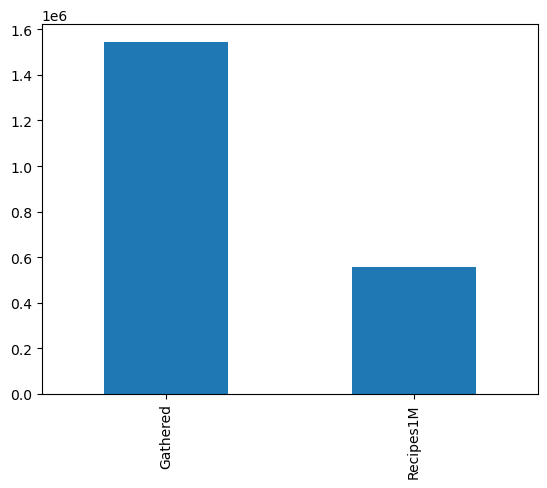

In [13]:
df_cleaned['source'].value_counts().plot(kind='bar')

# EDA

In [9]:
df_gathered = df_cleaned[df_cleaned['source'] == 'Gathered']
df_1M = df_cleaned[df_cleaned['source'] == 'Recipes1M']

In [10]:
df_gathered.shape

(1545516, 5)

In [11]:
df_gathered = df_gathered.drop_duplicates(subset='title', keep='first')

In [12]:
df_gathered.shape # dataset is cut by 50% after removing duplicated titles

(852029, 5)

In [16]:
df_gathered = df_gathered.drop('source', axis=1)

In [17]:
df_gathered.head()

,title,ingredients,directions,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [18]:
df.to_csv(r'C:\Users\junfe\IOD Labs\Capstone\recipe_gathered.csv', index=False)

# Basic Satistics

In [18]:
df_gathered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852029 entries, 0 to 1643094
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        852029 non-null  object
 1   ingredients  852029 non-null  object
 2   directions   852029 non-null  object
 3   source       852029 non-null  object
 4   NER          852029 non-null  object
dtypes: object(5)
memory usage: 39.0+ MB


# Title Analysis

310


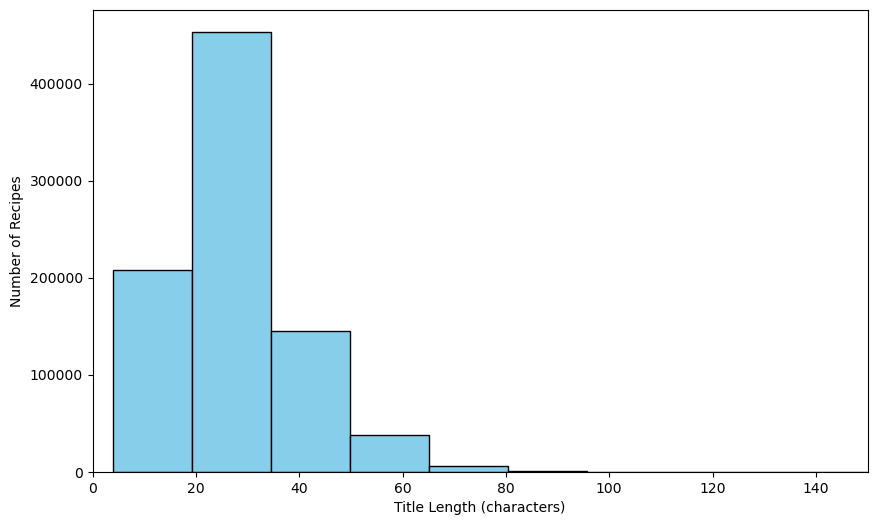

In [19]:
title_lengths = df_gathered['title'].apply(len)
print(max(title_lengths))

# Plot the distribution of title lengths
plt.figure(figsize=(10, 6))
plt.hist(title_lengths, bins=20, color='skyblue', edgecolor='black')
#plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length (characters)')
plt.ylabel('Number of Recipes')
plt.xlim(0, 150) 
plt.show()

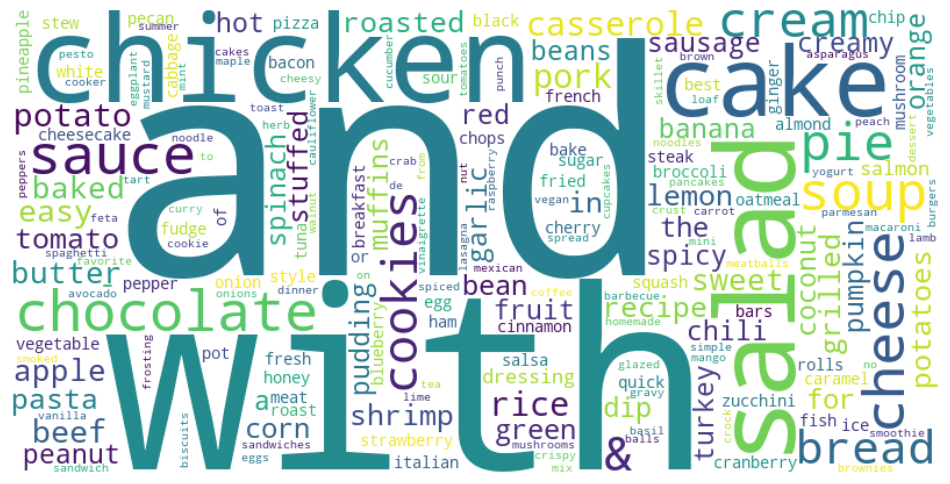

In [20]:
# Split titles into words and count occurrences
all_words = ' '.join(df_gathered['title']).lower().split()
word_counts = Counter(all_words)

# Generate a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Most Common Words in Recipe Titles')
plt.show()

# Ingredient Analysis

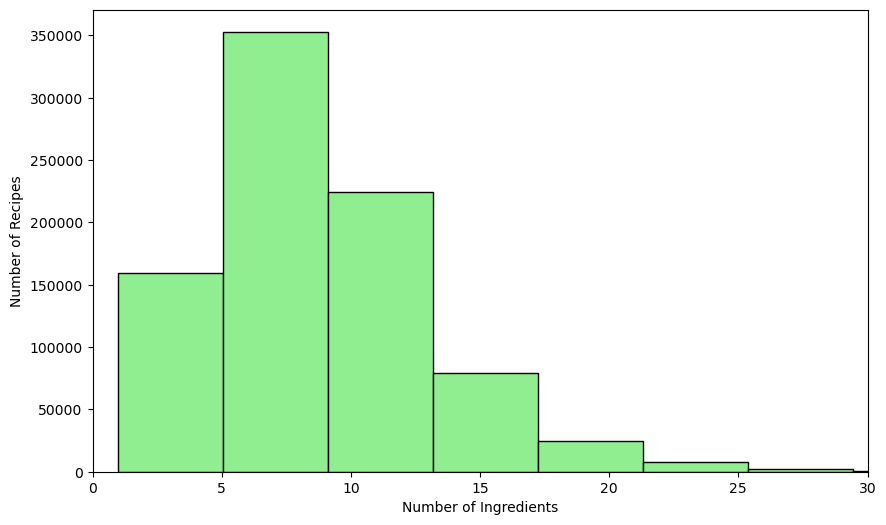

In [21]:
# Calculate the number of ingredients for each recipe
num_ingredients = df_gathered['ingredients'].apply(lambda x: len(eval(x)))

# Plot the distribution of the number of ingredients
plt.figure(figsize=(10, 6))
plt.hist(num_ingredients, bins=100, color='lightgreen', edgecolor='black')
#plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.xlim(0, 30) 
plt.show()

# majority of recipe contain 5 to 10 ingredients

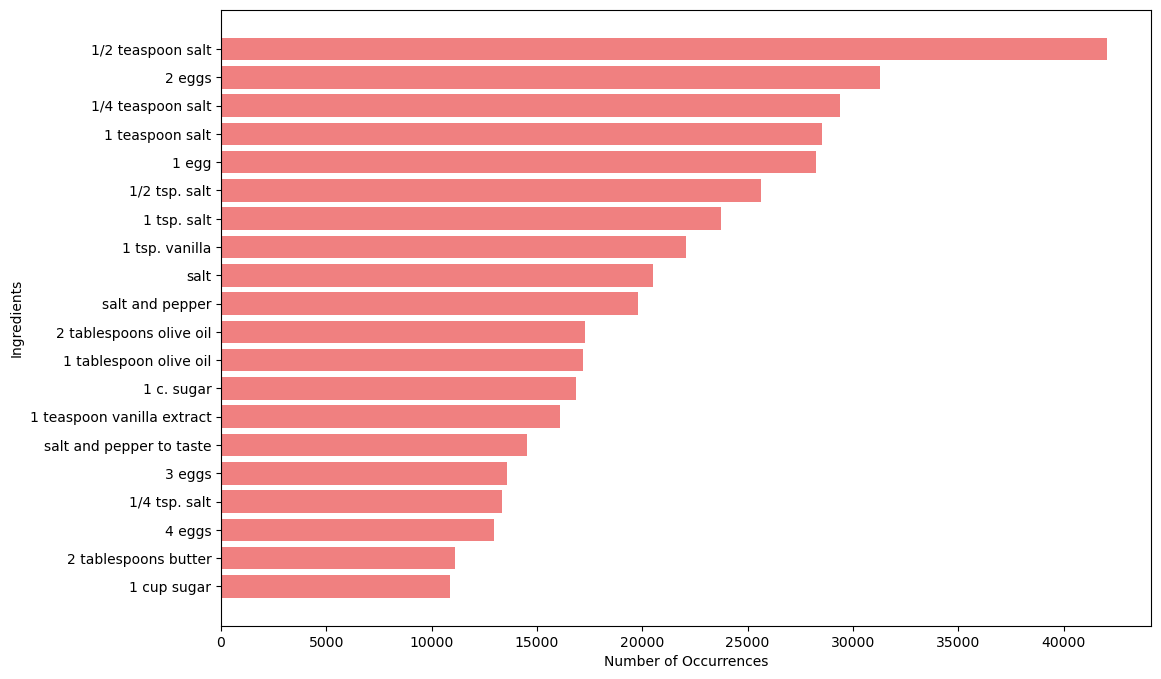

In [22]:
all_ingredients = [ingredient for sublist in df_gathered['ingredients'].apply(eval).tolist() for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Get the 20 most common ingredients
common_ingredients = ingredient_counts.most_common(20)

# Plot the most common ingredients
plt.figure(figsize=(12, 8))
ingredients, counts = zip(*common_ingredients)  # Unzip the tuple
plt.barh(ingredients, counts, color='lightcoral')
plt.xlabel('Number of Occurrences')
plt.ylabel('Ingredients')
#plt.title('20 Most Common Ingredients')
plt.gca().invert_yaxis()  # Display the most common ingredient at the top
plt.show()

# NER Analysis

In [23]:
import ast

# Abstract Syntax Trees 
# Initial problem with for loop was that the word was split into individual characters

# Initialize the new list
ingredient_list = []

# Split the words based on commas and preserve multi-word phrases
for words_string in df_gathered['NER']:
    words_list = ast.literal_eval(words_string)
    ingredient_list.extend(words_list)


In [24]:
# Create a dictionary to count the frequency of each word
ingredient_frequency_dict = Counter(ingredient_list)

# Print the ingredient frequency dictionary
my_dict = dict(sorted(ingredient_frequency_dict.items(), key=lambda x: len(x[0])))

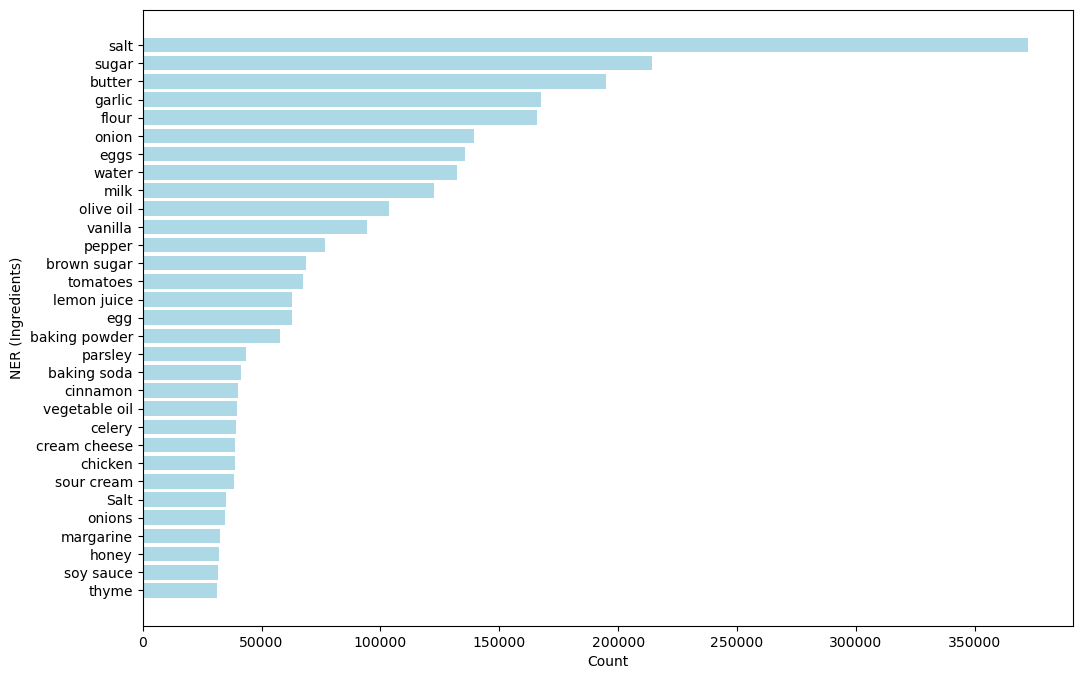

In [25]:
# Sort the dictionary by values in descending order
sorted_items = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)

top_30_keys = [item[0] for item in sorted_items[:31]]
top_30_values = [item[1] for item in sorted_items[:31]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_30_keys, top_30_values, color='lightblue')
plt.ylabel('NER (Ingredients)')
plt.xlabel('Count')
# plt.title('Top 30 Most Common Named Entities (Ingredients)')
plt.gca().invert_yaxis()  # Display the most common ingredient at the top
plt.show()

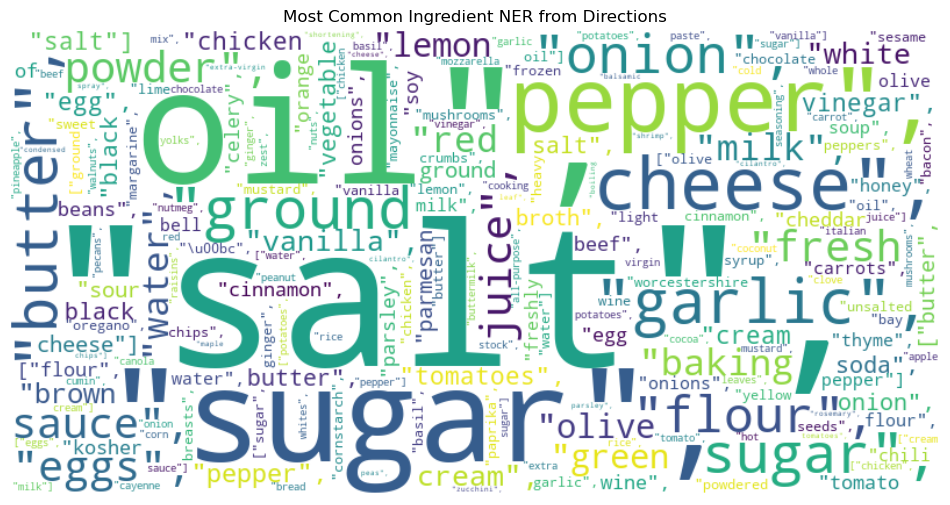

In [26]:
# Split titles into words and count occurrences
all_words = ' '.join(df_gathered['NER']).lower().split()
word_counts = Counter(all_words)

# Generate a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Ingredient NER from Directions')
plt.show()

# Correlation

0.2800521441200978

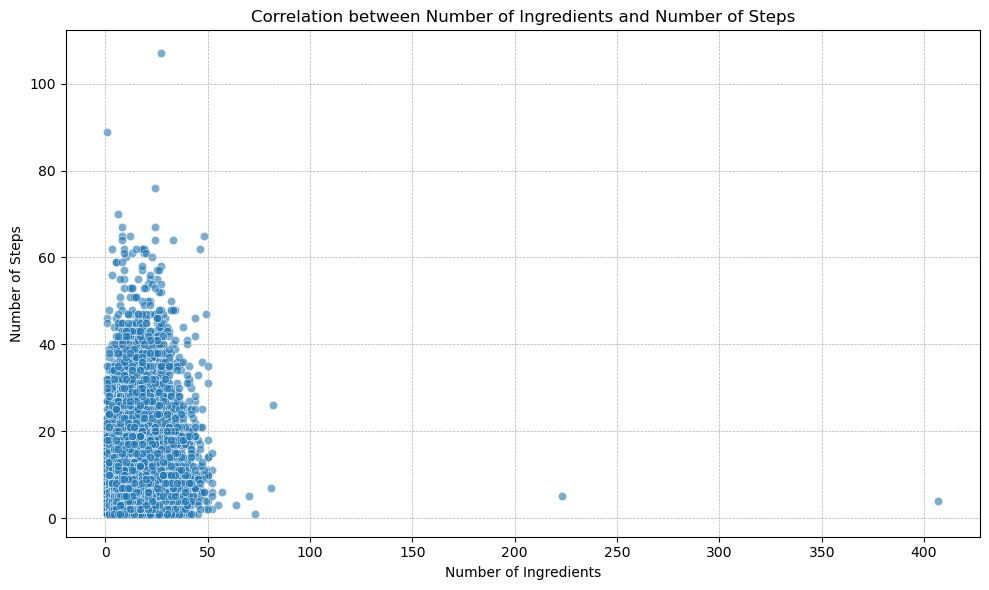

In [27]:
# Calculate the number of steps for each recipe
num_steps = df_gathered['directions'].apply(lambda x: len(eval(x)))

# Plotting the correlation between number of ingredients and number of steps
plt.figure(figsize=(10, 6))
plt.scatter(num_ingredients, num_steps, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title('Correlation between Number of Ingredients and Number of Steps')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Steps')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Calculate the correlation coefficient
correlation_coefficient = num_ingredients.corr(num_steps)

correlation_coefficient # Not that important but good to know

# 7. Outliers

In [28]:
# Function to detect outliers using the IQR method
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Detecting outliers in the number of ingredients
ingredient_outliers = detect_outliers(num_ingredients)

# Detecting outliers in the number of steps
steps_outliers = detect_outliers(num_steps)

len(steps_outliers)

30815

In [29]:
df_cleaned_no_outliers = df_gathered.drop(steps_outliers.index)

# Display the shape of the DataFrame before and after removing outliers
original_shape_cleaned = df_gathered.shape
after_outliers_removed_shape = df_cleaned_no_outliers.shape

original_shape_cleaned, after_outliers_removed_shape

((852029, 5), (821214, 5))

In [30]:
df_cleaned_no_outliers.head()

,title,ingredients,directions,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


# Ingredients Prediction Based on  Partial Directions / Directions

In [31]:
df_cleaned_no_outliers.shape

(821214, 5)

In [32]:
len(df_cleaned_no_outliers)/100

8212.14

In [33]:
df_subset = df_cleaned_no_outliers.sample(10000, random_state =42)
df_subset.shape

(10000, 5)

In [34]:
df_subset = df_subset.reset_index(drop=True)

In [35]:
df_subset

,title,ingredients,directions,source,NER
0,Easy Fruit Icebox Pie,"[""2 deep dish pie crusts, cooked"", ""4 bananas""...","[""Slice 2 bananas in each pie crust."", ""Mix cr...",Gathered,"[""dish pie crusts"", ""bananas"", ""cream cheese"",..."
1,"Quick, Easy, Awesome Green Bean Soup","[""6 cups chicken broth (use fresh, canned low-...","[""Combine first 5 ingredients in a pot and bri...",Gathered,"[""chicken broth"", ""salt"", ""thyme"", ""bay leaf"",..."
2,Mother'S Best Fudge Cake,"[""3 (1 oz.) sq. unsweetened chocolate, melted""...","[""Combine chocolate, 1/2 cup milk, well beaten...",Gathered,"[""unsweetened chocolate"", ""milk"", ""egg"", ""suga..."
3,Green Beans With Dill Vinagrette,"[""2 lbs. fresh green beans, trimmed"", ""3 Tbs. ...","[""Cook beans until tender, bur still crisp"", ""...",Gathered,"[""fresh green beans"", ""olive oil"", ""salt"", ""wh..."
4,Short Cut Chili Sauce,"[""3 qt. peeled and chopped tomatoes"", ""2 c. ch...","[""Combine tomatoes, celery, onions, pepper and...",Gathered,"[""tomatoes"", ""celery"", ""onions"", ""green pepper..."
...,...,...,...,...,...
9995,Guadalajara Beef,"[""12 ounces dark beer"", ""1/4 cup low sodium so...","[""Make marinade by combining beer, soy sauce, ...",Gathered,"[""soy sauce"", ""garlic"", ""ground cumin"", ""chili..."
9996,Weight Watchers Chocolate Mousse,"[""1/3 c. cold water"", ""1 pkg. Knox gelatine"", ...","[""Blend cold water and gelatine in blender 1 m...",Gathered,"[""cold water"", ""gelatine"", ""chocolate"", ""artif..."
9997,Charred Squid Skewers On Garlic Toast With Aru...,"[""12 (10-inch) bamboo skewers"", ""2 pounds clea...","[""Soak bamboo skewers in water 30 minutes; dra...",Gathered,"[""bamboo skewers"", ""tentacles"", ""crusty bread""..."
9998,Curry Turkey Stir-Fry,"[""1/2 teaspoon cornstarch"", ""2 tablespoons red...","[""Mix first seven ingredients and, if desired,...",Gathered,"[""cornstarch"", ""soy sauce"", ""fresh cilantro"", ..."


In [36]:
random_sample = df_subset['ingredients'].sample(10, random_state = 0)
ing_list = random_sample.copy().tolist()
#ing_list

In [37]:
random_sample = df_subset['directions'].sample(10, random_state = 0)

In [38]:
df_10 = pd.DataFrame(random_sample)

In [39]:
values_list = df_10['directions'].copy().tolist()
#values_list

In [40]:
unit_map = {"ounces": "ounce ",
                "ounce": "ounce ",
                "oz.": "ounce ", 
                "oz": "ounce ",
                "ounce." : "ounce ",
                
                
                "c.": "cup ", 
                "c": "cup ", 
                "C": "cup ", 
                "cc": "mililiter ",
                "cups": "cup ", 
                "cup": "cup ", 
                'cl.': 'centilitre ', # cl. for some reason cannot be replaced
                'cl': 'centilitre ',

                
                "tbsp.": "tablespoon ", 
                "tbsp": "tablespoon ", 
                "tbs": "tablespoon ", 
                "tablespoons": "tablespoon ", 
                "tablespoon(s)": "tablespoon ",
                "tablespoon": "tablespoon ",
                
                "teaspoons": "teaspoon ", 
                "teaspoon": "teaspoon ",
                "tsp.": "teaspoon ", 
                "tsp": "teaspoon ", 
                "t.": "teaspoon ",
                
                "lb.": "pound ", 
                "lb": "pound ",
                "lbs": "pound ",
                "pound": "pound ", 
                "pounds": 'pound ',
                
                "kg.": "kilogram ", 
                "mg.": "miligram ", 
                "grams": "gram ", 
                "gram": "gram ",
                "gm": "gram ", 
                "g.": "gram ", 
                "g": "gram ",
                
                "qts": "quart ", 
                "qts.": "quart ", 
                "quarts": "quart ", 
                "quart": "quart ", 
                "qt.": "quart ", 
                "qt": "quart ", 
                
                "gal.": "galon ",
                
                "pints": "pint ", 
                "pint": "pint ", 
                "pt.": "pint ", 
                
                "liters": "liter ",
                "liter": "liter ", 
                "l": "liter ", 
                "ml": "mililiter ", 
                
                
                
                "inches": "inch ", 
                "inch": "inch ",
                
                "cm": "centimeter ",
               
                "can": "can ",
                "cans": "can ",
               
                "stick": "stick ",
                "sticks": "stick ",
                
                "bottle": "bottle ",
                
                "drops": "drop ", 
                "drop": "drop ",
                "pkg.": 'package ',
                'salt&amp;' : 'salt and',
                "&": "and "
               }

In [41]:
def lowercase_text(text):
    if isinstance(text, str):
        return text.lower()
    else:
        return text

df_subset_lower = df_subset.applymap(lowercase_text)

In [42]:
df_subset_lower.head() # all to lowercase

,title,ingredients,directions,source,NER
0,easy fruit icebox pie,"[""2 deep dish pie crusts, cooked"", ""4 bananas""...","[""slice 2 bananas in each pie crust."", ""mix cr...",gathered,"[""dish pie crusts"", ""bananas"", ""cream cheese"",..."
1,"quick, easy, awesome green bean soup","[""6 cups chicken broth (use fresh, canned low-...","[""combine first 5 ingredients in a pot and bri...",gathered,"[""chicken broth"", ""salt"", ""thyme"", ""bay leaf"",..."
2,mother's best fudge cake,"[""3 (1 oz.) sq. unsweetened chocolate, melted""...","[""combine chocolate, 1/2 cup milk, well beaten...",gathered,"[""unsweetened chocolate"", ""milk"", ""egg"", ""suga..."
3,green beans with dill vinagrette,"[""2 lbs. fresh green beans, trimmed"", ""3 tbs. ...","[""cook beans until tender, bur still crisp"", ""...",gathered,"[""fresh green beans"", ""olive oil"", ""salt"", ""wh..."
4,short cut chili sauce,"[""3 qt. peeled and chopped tomatoes"", ""2 c. ch...","[""combine tomatoes, celery, onions, pepper and...",gathered,"[""tomatoes"", ""celery"", ""onions"", ""green pepper..."


In [43]:
def clean(text):
    
    if not isinstance(text, str):
        return text
    
    text = re.sub("\([^\)]*\)", " ", text)  # remove quotes
    text = re.sub(r'\{.*?\}', " ", text)    # remove curly brackets
    text = re.sub("(\s+|$\s+|\s+^)", " ", text)  # remove all additional white characters
    text = re.sub(r'\\', " ", text)         # remove backslash symbol
    return text

# Apply the clean to the dataframe
df_clean = df_subset_lower.applymap(clean)

In [44]:
def replace_units(ingredient):
    for old_unit, new_unit in unit_map.items():
        pattern = rf'\b{old_unit}\b'
        ingredient = re.sub(pattern, new_unit, ingredient)
    return ingredient

df_clean['ingredients'] = df_clean['ingredients'].apply(replace_units)

In [45]:
df_clean.head()

,title,ingredients,directions,source,NER
0,easy fruit icebox pie,"[""2 deep dish pie crusts, cooked"", ""4 bananas""...","[""slice 2 bananas in each pie crust."", ""mix cr...",gathered,"[""dish pie crusts"", ""bananas"", ""cream cheese"",..."
1,"quick, easy, awesome green bean soup","[""6 cup chicken broth "", ""1 teaspoon salt ""...","[""combine first 5 ingredients in a pot and bri...",gathered,"[""chicken broth"", ""salt"", ""thyme"", ""bay leaf"",..."
2,mother's best fudge cake,"[""3 sq. unsweetened chocolate, melted"", ""1/2 c...","[""combine chocolate, 1/2 cup milk, well beaten...",gathered,"[""unsweetened chocolate"", ""milk"", ""egg"", ""suga..."
3,green beans with dill vinagrette,"[""2 pound . fresh green beans, trimmed"", ""3 t...","[""cook beans until tender, bur still crisp"", ""...",gathered,"[""fresh green beans"", ""olive oil"", ""salt"", ""wh..."
4,short cut chili sauce,"[""3 quart . peeled and chopped tomatoes"", ""2 c...","[""combine tomatoes, celery, onions, pepper and...",gathered,"[""tomatoes"", ""celery"", ""onions"", ""green pepper..."


In [46]:
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return nouns

# Apply the function on a subset of the 'ingredients' column for demonstration
df_clean['nouns'] = df_clean['ingredients'].apply(extract_nouns)


In [47]:
def find_problematic_row(df, column_name):
    problematic_rows = []
    for index, row in df.iterrows():
        try:
            eval(row[column_name])
        except Exception as e:
            problematic_rows.append((index, str(e)))
    return problematic_rows
# if cannot be iterrate, return row index
problematic_rows = find_problematic_row(df_clean, 'ingredients')

problematic_rows

[(27, 'invalid syntax. Perhaps you forgot a comma? (<string>, line 1)'),
 (117, 'unterminated string literal (detected at line 1) (<string>, line 1)'),
 (318, 'invalid syntax. Perhaps you forgot a comma? (<string>, line 1)'),
 (407, 'unterminated string literal (detected at line 1) (<string>, line 1)'),
 (423, 'unterminated string literal (detected at line 1) (<string>, line 1)'),
 (435, 'unterminated string literal (detected at line 1) (<string>, line 1)'),
 (520, 'invalid syntax. Perhaps you forgot a comma? (<string>, line 1)'),
 (526, 'invalid syntax. Perhaps you forgot a comma? (<string>, line 1)'),
 (781, 'unterminated string literal (detected at line 1) (<string>, line 1)'),
 (1229, 'unterminated string literal (detected at line 1) (<string>, line 1)'),
 (1316, 'unterminated string literal (detected at line 1) (<string>, line 1)'),
 (1431, 'invalid syntax. Perhaps you forgot a comma? (<string>, line 1)'),
 (1571, 'unterminated string literal (detected at line 1) (<string>, line 1

In [48]:
problematic_row_indices = [row[0] for row in problematic_rows]

In [49]:
def replace_inner_quotes_split_method(s):
    # Split the string on commas to break it down into individual items
    items = s[2:-2].split('", "') # slice based on the 3rd character and 3rd last character
    # since they are " and "
    # Apply the replacement on each item
    items_modified = [item.replace('"', ' inch') for item in items]
    
    # Rejoin the modified items into a single string
    return '["' + '", "'.join(items_modified) + '"]'


df_clean.loc[problematic_row_indices, 'ingredients'] = df_clean.loc[problematic_row_indices, 'ingredients'].apply(replace_inner_quotes_split_method)

In [50]:
df_clean.dtypes

title          object
ingredients    object
directions     object
source         object
NER            object
nouns          object
dtype: object

In [51]:
def filter_alpha(lst):
    # This inner function checks if a string is entirely alphabetical
    def is_alpha(s):
        return s.isalpha()

    # Return a list containing only the alphabetical strings
    return [word for word in lst if is_alpha(word)]

# Assuming 'nouns' is a column containing lists
df_clean['words'] = df_clean['nouns'].apply(filter_alpha)

In [52]:
unique_values = list(set(unit_map.values()))
unique_values_cleaned = [value.split()[0] for value in unique_values] # remove whitespace
unique_values_cleaned

['quart',
 'pint',
 'package',
 'centimeter',
 'galon',
 'inch',
 'and',
 'drop',
 'teaspoon',
 'tablespoon',
 'ounce',
 'gram',
 'mililiter',
 'cup',
 'salt',
 'liter',
 'centilitre',
 'kilogram',
 'stick',
 'pound',
 'miligram',
 'bottle',
 'can']

In [53]:
df_clean['words'] = df_clean['words'].apply(lambda x: [word for word in x if word not in unique_values_cleaned])

In [54]:
df_clean.head()

,title,ingredients,directions,source,NER,nouns,words
0,easy fruit icebox pie,"[""2 deep dish pie crusts, cooked"", ""4 bananas""...","[""slice 2 bananas in each pie crust."", ""mix cr...",gathered,"[""dish pie crusts"", ""bananas"", ""cream cheese"",...","[dish, pie, crusts, bananas, cream, cheese, cu...","[dish, pie, crusts, bananas, cream, cheese, su..."
1,"quick, easy, awesome green bean soup","[""6 cup chicken broth "", ""1 teaspoon salt ""...","[""combine first 5 ingredients in a pot and bri...",gathered,"[""chicken broth"", ""salt"", ""thyme"", ""bay leaf"",...","[cup, chicken, broth, teaspoon, salt, sprig, t...","[chicken, broth, sprig, thyme, bay, leaf, oliv..."
2,mother's best fudge cake,"[""3 sq. unsweetened chocolate, melted"", ""1/2 c...","[""combine chocolate, 1/2 cup milk, well beaten...",gathered,"[""unsweetened chocolate"", ""milk"", ""egg"", ""suga...","[sq, chocolate, cup, milk, egg, cup, sugar, cu...","[sq, chocolate, milk, egg, sugar, sugar, vanil..."
3,green beans with dill vinagrette,"[""2 pound . fresh green beans, trimmed"", ""3 t...","[""cook beans until tender, bur still crisp"", ""...",gathered,"[""fresh green beans"", ""olive oil"", ""salt"", ""wh...","[pound, beans, tablespoon, olive, oil, teasp, ...","[beans, olive, oil, teasp, wine, vinegar, dill..."
4,short cut chili sauce,"[""3 quart . peeled and chopped tomatoes"", ""2 c...","[""combine tomatoes, celery, onions, pepper and...",gathered,"[""tomatoes"", ""celery"", ""onions"", ""green pepper...","[quart, tomatoes, cup, celery, cup, onions, cu...","[tomatoes, celery, onions, pepper, sugar, suga..."


In [180]:
# Create a binary matrix of ingredients
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
ingredient_matrix = mlb.fit_transform(df_clean['words'])
# Created nouns column because using NER column directly carry over the unicode representation not visible

# Convert the matrix to a DataFrame for better visualization
ingredient_matrix_df = pd.DataFrame(ingredient_matrix, columns=mlb.classes_)

print(ingredient_matrix.shape)

# 3017 columns before measurement removal

(10000, 2998)


In [182]:
ingredient_matrix_df
# remove measurement units

,aamchur,aborio,acai,accent,accompaniment,accompaniments,aceto,achiote,achote,acid,...,zabaglione,zatarain,zeera,zest,zinfandel,ziti,zucchini,zuccinis,zuchini,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Word level

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extracting the 'directions' column from the cleaned dataframe
directions = df_clean['directions']

# Vectorizing the 'directions' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english') # consider lowering the max_df for smaller vocab

directions_tfidf = tfidf_vectorizer.fit_transform(directions)

# Checking the shape of the resulting TF-IDF matrix
directions_tfidf.shape

(10000, 9243)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(directions_tfidf, ingredient_matrix, test_size=0.2, random_state=42)

In [184]:
X_train.shape

(8000, 9243)

In [185]:
y_train.shape

(8000, 2998)

In [186]:
%%time
model_1 = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)
model_1.fit(X_train, y_train)

CPU times: total: 13.5 s
Wall time: 1min 43s


OneVsRestClassifier(estimator=LogisticRegression(solver='sag'), n_jobs=-1)

In [66]:
def train_model(classifier, X_train, y_train, X_test, y_test):
    # fit the training dataset on the classifier
    classifier.fit(X_train, y_train)

    # predict the labels on validation dataset
    predictions = classifier.predict(X_test)

    print("Hamming Loss:", hamming_loss(y_test, predictions)) 
    print("Micro-average F1 Score:", f1_score(y_test, predictions, average='micro'))
    print("Macro-average F1 Score:", f1_score(y_test, predictions, average='macro', zero_division=0))
    
    # y_test no need to include as it is a global variable
    # might need to change when I use the other y2_train

In [187]:
%%time
train_model(model_1, X_train, y_train, X_test, y_test)

Hamming Loss: 0.0030303535690460307
Micro-average F1 Score: 0.4166559650699885
Macro-average F1 Score: 0.017422002993473035
CPU times: total: 15.6 s
Wall time: 1min 41s


The sag solver stands for Stochastic Average Gradient descent

Scalability: sag is an iterative method that's faster than other solvers for large datasets. It's a variant of stochastic gradient descent (SGD) but uses a random sample of previous gradient values. This makes it converge faster than the standard SGD.

Memory Efficiency: The sag solver uses a memory-efficient algorithm to compute the gradients. This makes it suitable for problems with a large number of samples or features.

L2 Regularization: The sag solver only supports L2 regularization. If you're using L2 regularization (or no regularization), then sag can be a good choice.

Multi-class Problems: For multi-class problems, sag handles multinomial loss efficiently.

OneVsRestClassifier can also be used for multilabel classification. To use this feature, provide an indicator matrix for the target y when calling .fit. In other words, the target labels should be formatted as a 2D binary (0/1) matrix, where [i, j] == 1 indicates the presence of label j in sample i. This estimator uses the binary relevance method to perform multilabel classification, which involves training one binary classifier independently for each label.

Hamming loss is the fraction of labels that are incorrectly predicted. <br>
It is the average Hamming distance between the true and predicted labels. <br>
Direct measure of how well the classifier's predictions match the true labels.

Micro-average F1 Score
It aggregates the contributions of all classes to compute the average metric. In a multi-label classification setup, micro-average is preferable if you suspect there might be an imbalance between the classes

The micro-average gives more weight to the more frequent labels. An F1 score of ~0.51 suggests that there's room for improvement. 

Macro-average F1 Score
It computes the metric independently for each class and then takes the average (hence treating all classes equally), which can be a problem with class imbalance.

The low score suggests that while the model might be doing well on common ingredients, it's likely struggling with less frequent ones. This is a common challenge in multi-label classification, especially when there's a class imbalance.


In [62]:
def predict_ingredients(directions, model):
    # 1. Preprocess the new directions
    preprocessed_directions = tfidf_vectorizer.transform([directions])

    # 2. Predict with the model
    predicted_matrix = model.predict(preprocessed_directions)

    # 3. Decode the predictions
    ingredients = mlb.inverse_transform(predicted_matrix)

    return ingredients[0]  # Return the list of predicted ingredients

# Test with a new recipe direction
new_directions = "Preheat oven to 350 degrees F (175 degrees C).Cream together the butter, white sugar, and brown sugar until smooth. Beat in the eggs one at a time, then stir in the vanilla. Dissolve baking soda in hot water. Add to batter along with salt. Stir in flour, chocolate chips, and nuts. Drop by large spoonfuls onto ungreased pans.Bake for about 10 minutes in the preheated oven, or until edges are nicely browned."
predicted_ingredients = predict_ingredients(new_directions, model_1)
print(predicted_ingredients)

('baking', 'butter', 'chips', 'chocolate', 'eggs', 'flour', 'soda', 'sugar', 'vanilla')


In [ ]:
# Might be useful but not so much now
from sklearn.metrics import roc_auc_score

y_test_np = y_test.to_numpy()
y_pred_np = np.array(y_pred)  # If y_pred isn't already a NumPy array

roc_auc_scores = []

# Loop through each ingredient
for i in range(y_test_np.shape[1]):
    if len(np.unique(y_test_np[:, i])) == 2:  # Check if both classes are present
        score = roc_auc_score(y_test_np[:, i], y_pred_np[:, i])
        roc_auc_scores.append(score)

roc_auc_macro = np.mean(roc_auc_scores)
roc_auc_micro = roc_auc_score(y_test_np.ravel(), y_pred_np.ravel())

print(f'Macro-average ROC AUC score (excluding ingredients with only one class in test set): {roc_auc_macro}')
print(f'Micro-average ROC AUC score: {roc_auc_micro}')

# N-gram

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extracting the 'directions' column from the cleaned dataframe
directions = df_clean['directions']

# Might be better representative if I used the NER column instead
# Vectorizing the 'directions' column using TF-IDF
tfidf_vectorizer_ngram = TfidfVectorizer(max_df=0.85, stop_words='english', ngram_range=(1,2)) # uni and bi-gram
X_ngram = tfidf_vectorizer_ngram.fit_transform(directions) # words like baking soda, white pepper

# Checking the shape of the resulting TF-IDF matrix
Xgram_train, Xgram_test, ygram_train, ygram_test = train_test_split(X_ngram, ingredient_matrix, test_size=0.2, random_state=42)

In [67]:
%%time
train_model(model_1, Xgram_train, ygram_train, Xgram_test, ygram_test) # included y_test as all slightly different

# 28 mins for mixed symbols + words + numbers
# 26 mins with only words for uni + bigram
# 20 mins with bigrams but a lot smaller F1 accuracy score

Hamming Loss: 0.0030303535690460307
Micro-average F1 Score: 0.4166559650699885
Macro-average F1 Score: 0.017422002993473035
CPU times: total: 14.2 s
Wall time: 1min 38s


In [69]:
new_directions = "Preheat oven to 350 degrees F (175 degrees C).Cream together the butter, white sugar, and brown sugar until smooth. Beat in the eggs one at a time, then stir in the vanilla. Dissolve baking soda in hot water. Add to batter along with salt. Stir in flour, chocolate chips, and nuts. Drop by large spoonfuls onto ungreased pans.Bake for about 10 minutes in the preheated oven, or until edges are nicely browned."
predicted_ingredients = predict_ingredients(new_directions, model_1)
print(predicted_ingredients)

('baking', 'butter', 'chips', 'chocolate', 'eggs', 'flour', 'soda', 'sugar', 'vanilla')


In [ ]:
y_test_np = y_test.to_numpy()
y_pred_np = np.array(y_pred)  # If y_pred isn't already a NumPy array

roc_auc_scores = []

# Loop through each ingredient
for i in range(y_test_np.shape[1]):
    if len(np.unique(y_test_np[:, i])) == 2:  # Check if both classes are present
        score = roc_auc_score(y_test_np[:, i], y_pred_np[:, i])
        roc_auc_scores.append(score)

roc_auc_macro = np.mean(roc_auc_scores)
roc_auc_micro = roc_auc_score(y_test_np.ravel(), y_pred_np.ravel())

print(f'Macro-average ROC AUC score (excluding ingredients with only one class in test set): {roc_auc_macro}')
print(f'Micro-average ROC AUC score: {roc_auc_micro}')

In [ ]:
# choose random index to show result of confusion matrix

y_test_np = y_test.to_numpy()
y_pred_np = np.array(y_pred)

# For a single ingredient, say the ingredient at index 'i'
i = np.random(range(0,10000)) # Index range from 0 - 10000
ingredient_name = mlb.classes_[i]
cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i])

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f'Not {ingredient_name}', ingredient_name], yticklabels=[f'Not {ingredient_name}', ingredient_name])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix for {ingredient_name}')
plt.show()

Next Steps:

Investigate the misclassifications: Look at the recipes where the predictions were off and try to identify patterns.

Feature Engineering: Explore other ways to represent the directions, like using word embeddings (e.g., Word2Vec or GloVe) or more advanced models like BERT.

Model Complexity: Consider more complex models like Random Forests, Gradient Boosting Machines, or even neural networks if computational resources allow.

Class Weights: Given the potential class imbalance, adjust class weights in the classification algorithm to give more importance to less frequent ingredients.

Data Augmentation: Consider gathering more data or using techniques to augment the existing data.

# Random Forest

In [71]:
%%time
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42)

train_model(rf_classifier, X_train, y_train, X_test, y_test)
# Bad choice out of memory if run without specific parameters
# consider max_samples default = X_train.shape[0] == 8000
# Tried going for higher depth on Google Collab but ran out of system RAM and crashed

Hamming Loss: 0.0036304202801867914
Micro-average F1 Score: 0.16559337626494938
Macro-average F1 Score: 0.002134318411341679
CPU times: total: 8min 57s
Wall time: 9min 13s


In [73]:
predicted_ingredients = predict_ingredients(new_directions, rf_classifier)
print(predicted_ingredients)

('butter', 'eggs', 'flour', 'sugar', 'vanilla')


# Boosting Machine

In [ ]:
%%time
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(objective="binary:logistic", n_estimators=100)

# Use MultiOutputClassifier to wrap the XGBoost model
multi_label_classifier = MultiOutputClassifier(xgb_classifier)

# Train the model
train_model(multi_label_classifier, X_train, y_train, y_test)

# takes 1 hr 32 mins

In [ ]:
new_directions = "Preheat oven to 350 degrees F (175 degrees C).Cream together the butter, white sugar, and brown sugar until smooth. Beat in the eggs one at a time, then stir in the vanilla. Dissolve baking soda in hot water. Add to batter along with salt. Stir in flour, chocolate chips, and nuts. Drop by large spoonfuls onto ungreased pans.Bake for about 10 minutes in the preheated oven, or until edges are nicely browned."
predicted_ingredients = predict_ingredients(new_directions, multi_label_classifier)
print(predicted_ingredients)

# Word2Vec

In [74]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys())) 
# might consider using pretrained model if tome allows

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [75]:
from gensim.models import Word2Vec

# Tokenize your directions
tokenized_directions = [dir_.split() for dir_ in df_clean['directions']]

# Train a Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_directions, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save("word2vec.model")

# Vectorize directions by averaging word vectors
def vectorize_direction(dir_):
    return np.mean([w2v_model.wv[word] for word in dir_ if word in w2v_model.wv.index_to_key], axis=0)

vectorized_directions = [vectorize_direction(dir_) for dir_ in tokenized_directions]


In [77]:
X2_train, X2_test, y2_train, y2_test = train_test_split(vectorized_directions, ingredient_matrix, test_size=0.2, random_state=42)
model_2 = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)

In [79]:
%%time
train_model(model_2, X2_train, y2_train, X2_test, y2_test)

Hamming Loss: 0.0036400933955970647
Micro-average F1 Score: 0.2379189944134078
Macro-average F1 Score: 0.004448040417694166
CPU times: total: 4min 17s
Wall time: 7min 35s


In [128]:
def get_avg_word2vec(tokens_list, vector, generate_missing=False, k=100): # k = vector length should match word2vec 
    """
    Get the average word2vec vectors for a list of tokens.
    """
    if len(tokens_list)<1: # if list is empty return zero vector
        return np.zeros(k)
    if generate_missing: # if True, generate random vectors for the words not in model
        vectorized = [vector.wv[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else: # otherwise assign zero vector to those words
        vectorized = [vector.wv[word] if word in vector.wv else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length) #  averages the vectors of all tokens to obtain a single vector representing the entire list of tokens
    return averaged

In [129]:
def predict_ingredients_w2v(directions, model):
    # Tokenize the directions
    tokens = directions.split()

    # Get the average Word2Vec vector for the tokens
    preprocessed_directions = get_avg_word2vec(tokens, w2v_model) #w2v_model is our saved w2v model
    
    # Predict with the model
    predicted_matrix = model.predict([preprocessed_directions])

    # Decode the predictions
    ingredients = mlb.inverse_transform(predicted_matrix)

    return ingredients[0]

In [83]:
new_directions = "Preheat oven to 350 degrees F (175 degrees C).Cream together the butter, white sugar, and brown sugar until smooth. Beat in the eggs one at a time, then stir in the vanilla. Dissolve baking soda in hot water. Add to batter along with salt. Stir in flour, chocolate chips, and nuts. Drop by large spoonfuls onto ungreased pans.Bake for about 10 minutes in the preheated oven, or until edges are nicely browned."
predicted_ingredients = predict_ingredients_w2v(new_directions, model_2)
print(predicted_ingredients)

('butter', 'eggs', 'flour', 'sugar', 'vanilla')


In [ ]:
# Does not perform that much better as compared to tdif but takes far longer time
# Will probably increase if I were to increase the vector size but the overall time required will increase

## Problem with NER 

Need to train_test_split raw version before transforming might have some problems with raw version of data...

In [105]:
df_clean['NER'] = df_clean['NER'].apply(ast.literal_eval) # Need to convert string into actual 
df_clean['NER']

0       [dish pie crusts, bananas, cream cheese, sugar...
1       [chicken broth, salt, thyme, bay leaf, olive o...
2       [unsweetened chocolate, milk, egg, sugar, shor...
3       [fresh green beans, olive oil, salt, white win...
4       [tomatoes, celery, onions, green pepper, salt,...
                              ...                        
9995    [soy sauce, garlic, ground cumin, chili powder...
9996    [cold water, gelatine, chocolate, artificial s...
9997    [bamboo skewers, tentacles, crusty bread, garl...
9998    [cornstarch, soy sauce, fresh cilantro, honey,...
9999    [flour, baking powder, soda, salt, cinnamon, n...
Name: NER, Length: 10000, dtype: object

In [188]:
directions

0       ["slice 2 bananas in each pie crust.", "mix cr...
1       ["combine first 5 ingredients in a pot and bri...
2       ["combine chocolate, 1/2 cup milk, well beaten...
3       ["cook beans until tender, bur still crisp", "...
4       ["combine tomatoes, celery, onions, pepper and...
                              ...                        
9995    ["make marinade by combining beer, soy sauce, ...
9996    ["blend cold water and gelatine in blender 1 m...
9997    ["soak bamboo skewers in water 30 minutes; dra...
9998    ["mix first seven ingredients and, if desired,...
9999    ["mix and drop by spoonfuls on cookie sheet.",...
Name: directions, Length: 10000, dtype: object

In [176]:
# Splitting the data first
Xner_train_raw, Xner_test_raw, yner_train_raw, yner_test_raw = train_test_split(directions, df_clean['NER'], test_size=0.2, random_state=42)

# Fitting the MultiLabelBinarizer only on the training data
mlb = MultiLabelBinarizer()
yner_train = mlb.fit_transform(yner_train_raw)

# Transforming the test data using the same mlb instance
yner_test = mlb.transform(yner_test_raw)

C:\Users\junfe\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) [' u00bc red - yellow', ' u00bc red onion', ' u00bc sweet onion', '# ground beef', '# ground lamb', '# ground pork', "'s mustard", "'s peppers", "'s u00ae", '+ up', '-salt', 'acid powder', 'additional whipped topping', 'additions', 'adzuki bean filling', 'ajinomoto', 'alfredo mix', 'almond flavored liqueur', 'almond liqueur', 'almond oil', 'almond toffee', 'amaretto', 'american cheese slices', 'amount bacon', 'amount of milk', 'anaheim chilies', 'ancho chilies', 'andes candies', 'angelica leaves', 'aniseed', 'apple brandy', 'apple cider could', 'applies', 'apricot paste', 'arrowroot starch/flour', 'assemble', 'baby back ribs', 'baby capers', 'baby food', 'baby squash', 'backfin crabmeat', 'bacon pan drippings', 'bag ice', 'bagel', 'bags', 'bags of semi-sweet chocolate chips', 'baguette slices', 'bailey irish cream', 'baking powde', 'baking sheet', 'banana pepper', 'banana-', '

In [177]:
yner_train_raw.shape

(8000,)

In [109]:
# Vectorizing the directions using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english')
Xner_train = tfidf_vectorizer.fit_transform(Xner_train_raw)
Xner_test = tfidf_vectorizer.transform(Xner_test_raw)

In [112]:
%%time
train_model(ner_model_1, Xner_train, yner_train, Xner_test, yner_test)

Hamming Loss: 0.0011329371540214914
Micro-average F1 Score: 0.3004071784044639
Macro-average F1 Score: 0.004001545612654689
CPU times: total: 30.1 s
Wall time: 3min 49s


In [111]:
predicted_ingredients = predict_ingredients(new_directions, ner_model_1)
print(predicted_ingredients)

('baking soda', 'butter', 'eggs', 'flour', 'salt', 'sugar', 'vanilla', 'white sugar')


## N-gram

In [114]:
tfidf_vectorizer_ngram = TfidfVectorizer(max_df=0.85, stop_words='english', ngram_range=(1,2))
Xner_gram_train = tfidf_vectorizer_ngram.fit_transform(Xner_train_raw)
Xner_gram_test = tfidf_vectorizer_ngram.transform(Xner_test_raw)

In [117]:
%%time
train_model(ner_model_1, Xner_gram_train, yner_train, Xner_gram_test, yner_test)

Hamming Loss: 0.0011662324975577987
Micro-average F1 Score: 0.2550956738768719
Macro-average F1 Score: 0.0019853288158174333
CPU times: total: 1min 23s
Wall time: 1h 5min 32s


# Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42)

In [ ]:
%%time
train_model(rf_classifier, Xner_train, yner_train, Xner_test, yner_test)
# Not going to use predict ingredients just for time-saving reasons

# XGB classifier

In [118]:
%%time
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(objective="binary:logistic", n_estimators=100)

# Use MultiOutputClassifier to wrap the XGBoost model
multi_label_classifier = MultiOutputClassifier(xgb_classifier)

# Train the model
train_model(multi_label_classifier, Xner_train, yner_train, Xner_test, yner_test)

Hamming Loss: 0.0009938130901986323
Micro-average F1 Score: 0.5085741888736817
Macro-average F1 Score: 0.02869798434535412
CPU times: total: 1h 31min 59s
Wall time: 30min 24s


In [120]:
predicted_ingredients = predict_ingredients(new_directions, multi_label_classifier)
print(predicted_ingredients)

('baking soda', 'brown sugar', 'butter', 'eggs', 'flour', 'nuts', 'salt', 'vanilla', 'white sugar')


# Word2Vec

In [132]:
# Tokenize your directions
tokenized_directions = [dir_.split() for dir_ in df_clean['directions']]

# Train a Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_directions, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save("word2vec.model")

# Vectorize directions by averaging word vectors
def vectorize_direction(dir_):
    return np.mean([w2v_model.wv[word] for word in dir_ if word in w2v_model.wv.index_to_key], axis=0)

vectorized_directions = [vectorize_direction(dir_) for dir_ in tokenized_directions]

In [162]:
# Splitting the data first
Xner_train, Xner_test, yner_train_raw, yner_test_raw = train_test_split(vectorized_directions, df_clean['NER'], test_size=0.2, random_state=42)

# Unlike the tdif can use the vectorized_directions before spliting

# Fitting the MultiLabelBinarizer only on the training data
mlb = MultiLabelBinarizer()
yner_train = mlb.fit_transform(yner_train_raw)

# Transforming the test data using the same mlb instance
yner_test = mlb.transform(yner_test_raw)

C:\Users\junfe\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) [' u00bc red - yellow', ' u00bc red onion', ' u00bc sweet onion', '# ground beef', '# ground lamb', '# ground pork', "'s mustard", "'s peppers", "'s u00ae", '+ up', '-salt', 'acid powder', 'additional whipped topping', 'additions', 'adzuki bean filling', 'ajinomoto', 'alfredo mix', 'almond flavored liqueur', 'almond liqueur', 'almond oil', 'almond toffee', 'amaretto', 'american cheese slices', 'amount bacon', 'amount of milk', 'anaheim chilies', 'ancho chilies', 'andes candies', 'angelica leaves', 'aniseed', 'apple brandy', 'apple cider could', 'applies', 'apricot paste', 'arrowroot starch/flour', 'assemble', 'baby back ribs', 'baby capers', 'baby food', 'baby squash', 'backfin crabmeat', 'bacon pan drippings', 'bag ice', 'bagel', 'bags', 'bags of semi-sweet chocolate chips', 'baguette slices', 'bailey irish cream', 'baking powde', 'baking sheet', 'banana pepper', 'banana-', '

In [163]:
model_1 = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)

In [155]:
print(type(y_train))
print(y_train.shape)

<class 'pandas.core.frame.DataFrame'>
(8000, 2998)


In [165]:
print(type(Xner_train))

<class 'list'>


In [166]:
Xner_train = np.array(Xner_train)

In [167]:
Xner_test = np.array(Xner_test)

In [168]:
print(type(Xner_train))
print(Xner_train.shape)

<class 'numpy.ndarray'>
(8000, 100)


In [161]:
Xner_test

array([[-0.19602849,  0.27875513,  0.30981055, ...,  0.03268523,
        -0.5084621 , -0.16669722],
       [-0.7828118 ,  0.06354181,  0.81504816, ...,  0.5094095 ,
        -0.37097982,  0.11030126],
       [ 0.14499004,  0.22785227,  0.25143057, ..., -0.03163272,
        -0.41598058,  0.14505683],
       ...,
       [-0.0320491 ,  0.15054615, -0.02086138, ...,  0.0377542 ,
        -0.57455343, -0.10144852],
       [-0.4412732 , -0.14355385,  0.07799325, ...,  0.38700545,
        -0.7816979 ,  0.20753226],
       [-0.35735196, -0.01915867,  0.19897805, ...,  0.11260944,
        -0.26754263,  0.02788572]], dtype=float32)

In [160]:
Xner_test.shape

(2000, 100)

In [169]:
%%time
train_model(model_1, Xner_train, yner_train, Xner_test, yner_test)

Hamming Loss: 0.0012666069684141973
Micro-average F1 Score: 0.17084998667732484
Macro-average F1 Score: 0.0011344690710289403
CPU times: total: 23.2 s
Wall time: 8min 6s


In [170]:
def get_avg_word2vec(tokens_list, vector, generate_missing=False, k=100): # k = vector length should match word2vec 
    """
    Get the average word2vec vectors for a list of tokens.
    """
    if len(tokens_list)<1: # if list is empty return zero vector
        return np.zeros(k)
    if generate_missing: # if True, generate random vectors for the words not in model
        vectorized = [vector.wv[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else: # otherwise assign zero vector to those words
        vectorized = [vector.wv[word] if word in vector.wv else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length) #  averages the vectors of all tokens to obtain a single vector representing the entire list of tokens
    return averaged

In [171]:
def predict_ingredients_w2v(directions, model):
    # Tokenize the directions
    tokens = directions.split()

    # Get the average Word2Vec vector for the tokens
    preprocessed_directions = get_avg_word2vec(tokens, w2v_model) #w2v_model is our saved w2v model
    
    # Predict with the model
    predicted_matrix = model.predict([preprocessed_directions])

    # Decode the predictions
    ingredients = mlb.inverse_transform(predicted_matrix)

    return ingredients[0]

In [172]:
new_directions = "Preheat oven to 350 degrees F (175 degrees C).Cream together the butter, white sugar, and brown sugar until smooth. Beat in the eggs one at a time, then stir in the vanilla. Dissolve baking soda in hot water. Add to batter along with salt. Stir in flour, chocolate chips, and nuts. Drop by large spoonfuls onto ungreased pans.Bake for about 10 minutes in the preheated oven, or until edges are nicely browned."
predicted_ingredients = predict_ingredients_w2v(new_directions, model_1)
print(predicted_ingredients)

('brown sugar', 'butter', 'eggs', 'flour', 'salt', 'sugar', 'vanilla')
